In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import warnings
# warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_curve, auc, confusion_matrix, roc_auc_score, roc_curve
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import joblib
import shap


C:\Users\verma\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

RANDOM_STATE = 42
sns.set_style('whitegrid')

In [4]:
## 2. Load Dataset
df = pd.read_csv('transaction.csv', parse_dates=['Time'])
print("Dataset shape:", df.shape)
display(df.head())

Dataset shape: (284807, 31)


C:\Users\verma\AppData\Local\Temp\ipykernel_16800\4223099956.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('transaction.csv', parse_dates=['Time'])


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
## 3. Basic Cleaning
df = df.drop_duplicates()
df = df[df['Class'].notnull()]  
print("Cleaned dataset shape:", df.shape)


Cleaned dataset shape: (283726, 31)


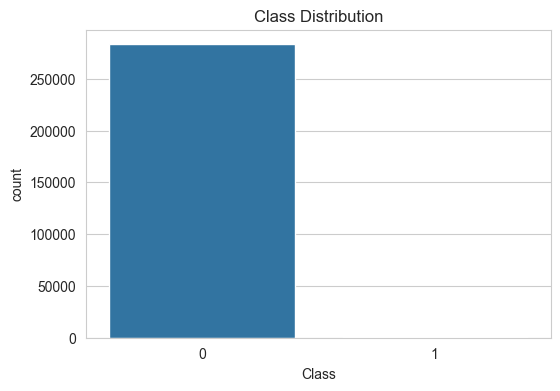

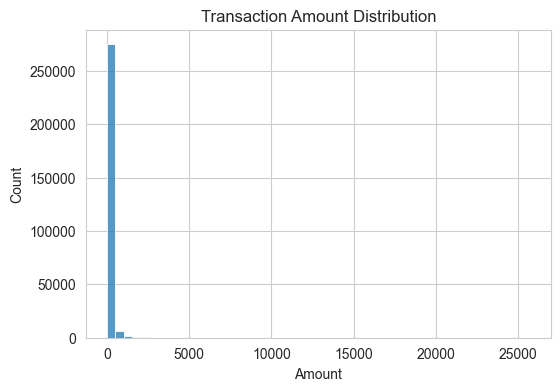

In [ ]:
## 4. EDA
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution')
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(df['Amount'], bins=50)  
plt.title('Transaction Amount Distribution')
plt.show()


In [12]:


## 5. Train/Val/Test Split
target = 'Class'
X = df.drop(columns=[target])
y = df[target]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RANDOM_STATE)

In [13]:
## 6. Preprocessing
NUMERIC = ['Time'] + [f'V{i}' for i in range(1, 29)] + ['Amount']

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# If no categorical features, we can skip this
preprocessor = ColumnTransformer([
    ('num', num_pipeline, NUMERIC)
])

In [16]:
## 7. Model + SMOTE
clf = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)

pipe = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', clf)
])

# 3️⃣ Smaller hyperparameter space for testing
param_dist = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10],
    'clf__min_samples_split': [2, 5]
}

# 4️⃣ Random search
search = RandomizedSearchCV(
    pipe,
    param_dist,
    n_iter=4,  # fewer combinations for speed
    scoring='average_precision',
    cv=2,      # fewer folds for speed
    verbose=2,
    n_jobs=4,  # parallel jobs
    random_state=RANDOM_STATE
)

search.fit(X_train, y_train)

print("Best params:", search.best_params_)


Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best params: {'clf__n_estimators': 200, 'clf__min_samples_split': 2, 'clf__max_depth': None}


In [17]:

## 8. Evaluation
y_pred = search.predict(X_test)
y_proba = search.predict_proba(X_test)[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recalls, precisions)
roc_auc = roc_auc_score(y_test, y_proba)

print('PR-AUC:', pr_auc)
print('ROC-AUC:', roc_auc)
print(classification_report(y_test, y_pred))


PR-AUC: 0.7966281132938716
ROC-AUC: 0.9339240110215047
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42488
           1       0.93      0.73      0.82        71

    accuracy                           1.00     42559
   macro avg       0.96      0.87      0.91     42559
weighted avg       1.00      1.00      1.00     42559



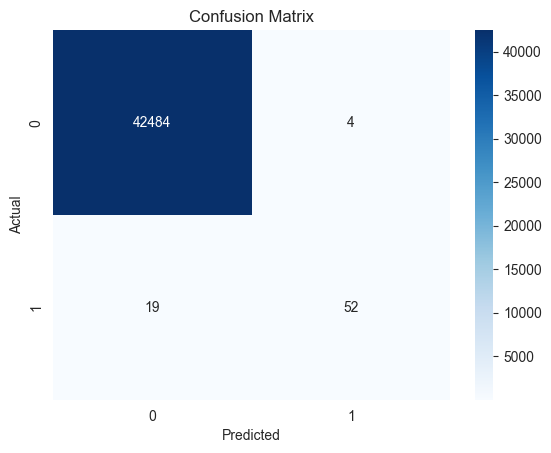

In [18]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

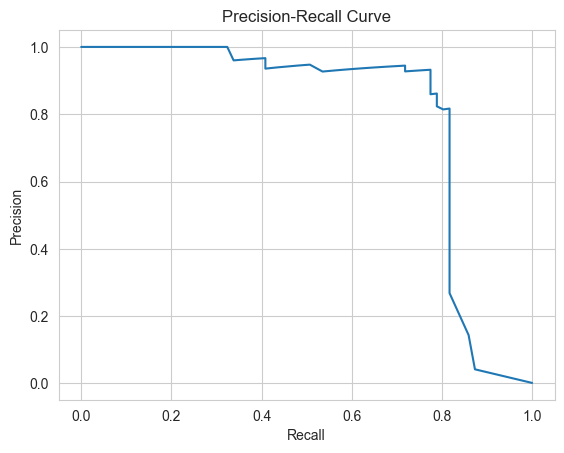

In [19]:
# PR Curve
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

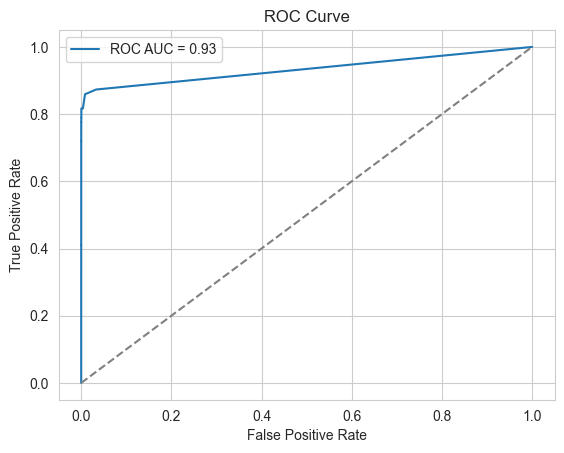

In [20]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [22]:
## 9. Save Model
joblib.dump(search.best_estimator_, 'model.pkl')

['model.pkl']

In [ ]:
## 10. SHAP Explainability
explainer = shap.TreeExplainer(search.best_estimator_.named_steps['clf'])
X_sample = X_test.sample(50, random_state=RANDOM_STATE)
X_trans = search.best_estimator_.named_steps['pre'].transform(X_sample)
shap_values = explainer.shap_values(X_trans)
shap.summary_plot(shap_values, X_trans)
```